# Download Python Libraries

In [44]:
!pip install pandas scikit-learn matplotlib seaborn plotly dash

# Import Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("carrie1/ecommerce-data")

print("Path to dataset files:", path)

100%|██████████| 7.20M/7.20M [00:00<00:00, 122MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/carrie1/ecommerce-data/versions/1


In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from dash import Dash, dcc, html

df = pd.read_csv(path + "/data.csv", encoding='ISO-8859-1')

# Data Cleaning
df = df.dropna(subset=['CustomerID'])  # Remove rows with missing CustomerID
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Convert to datetime
df = df[df['Quantity'] > 0]  # Keep only positive quantities
df = df[df['UnitPrice'] > 0]  # Keep only positive prices

# Create a 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# RFM (Recency, Frequency, Monetary) Analysis
reference_date = df['InvoiceDate'].max() + pd.DateOffset(1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Scale the RFM values for KMeans clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

<ipython-input-42-b2ed3125a927>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Visual Representation of data - Understanding of data

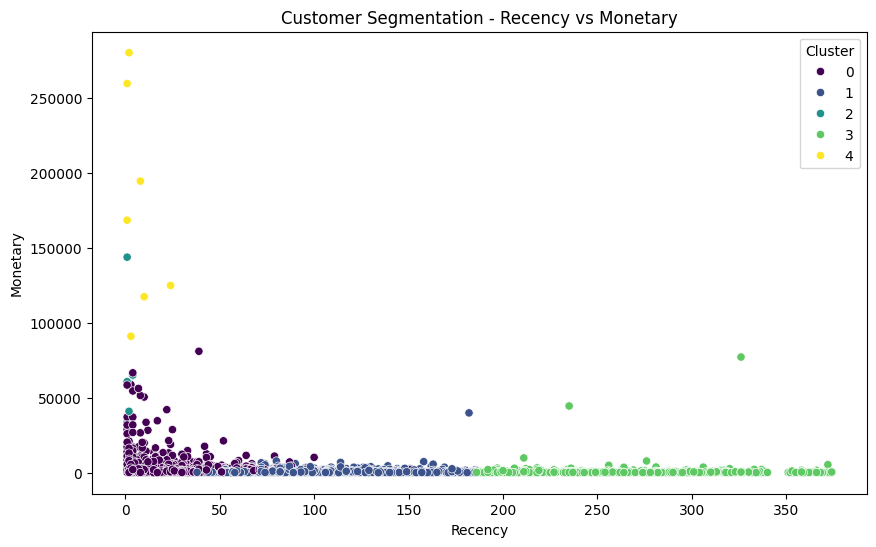

In [13]:
# Plotting Clusters using Seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster', palette='viridis')
plt.title('Customer Segmentation - Recency vs Monetary')
plt.show()

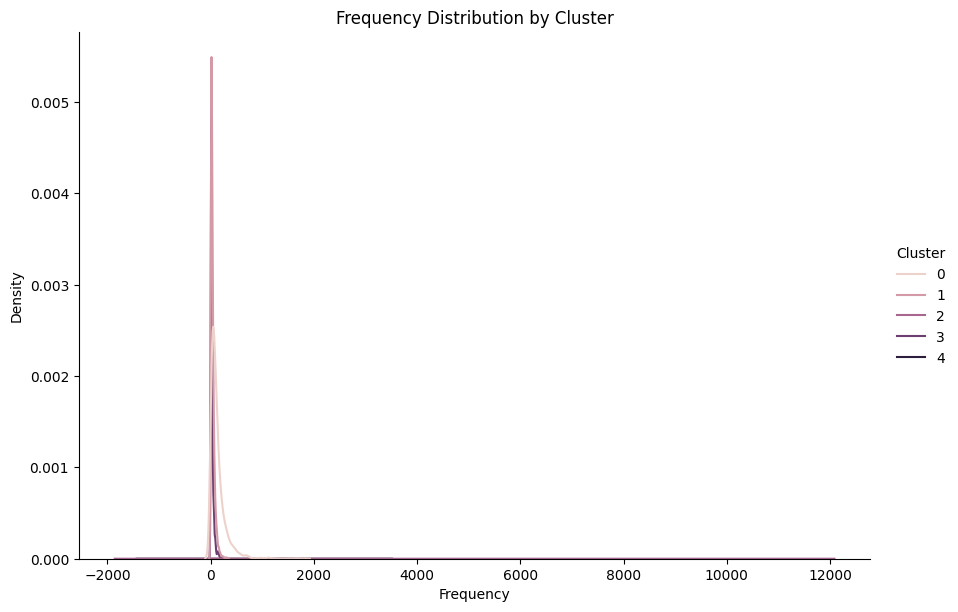

In [14]:
# Plot Frequency Distribution for Each Cluster
sns.displot(rfm, x='Frequency', hue='Cluster', kind='kde', height=6, aspect=1.5)
plt.title('Frequency Distribution by Cluster')
plt.show()

In [15]:
# Interactive 3D Plot using Plotly
fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary', color='Cluster',
                    title='3D View of Customer Segments')
fig.show()

<ipython-input-18-560315b0d984>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




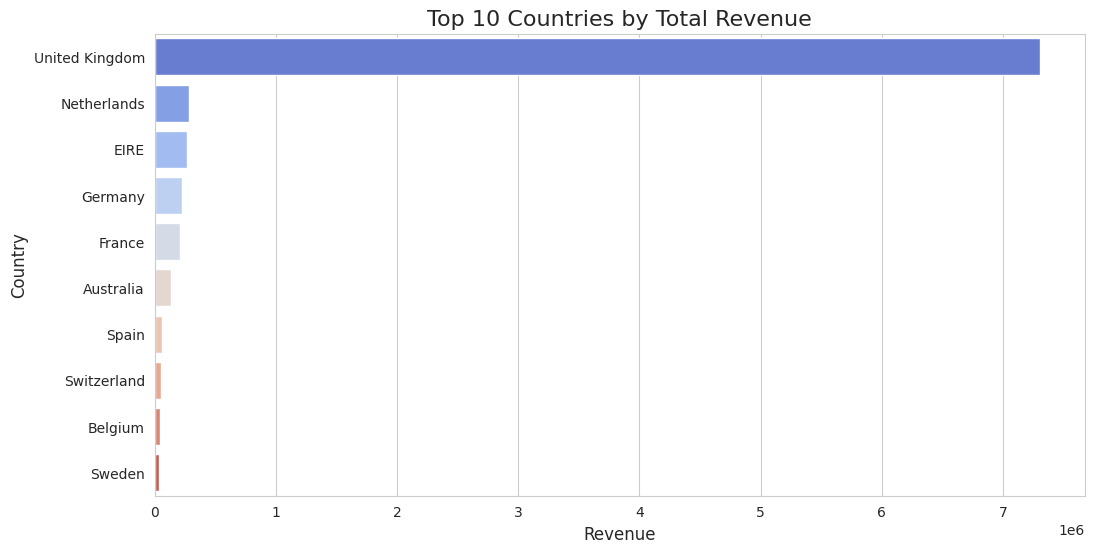

In [18]:
# Set the plot style
sns.set_style("whitegrid")

# 1. Plot: Top 10 Countries by Total Revenue
country_revenue = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_revenue.values, y=country_revenue.index, palette='coolwarm')
plt.title('Top 10 Countries by Total Revenue', fontsize=16)
plt.xlabel('Revenue', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.show()

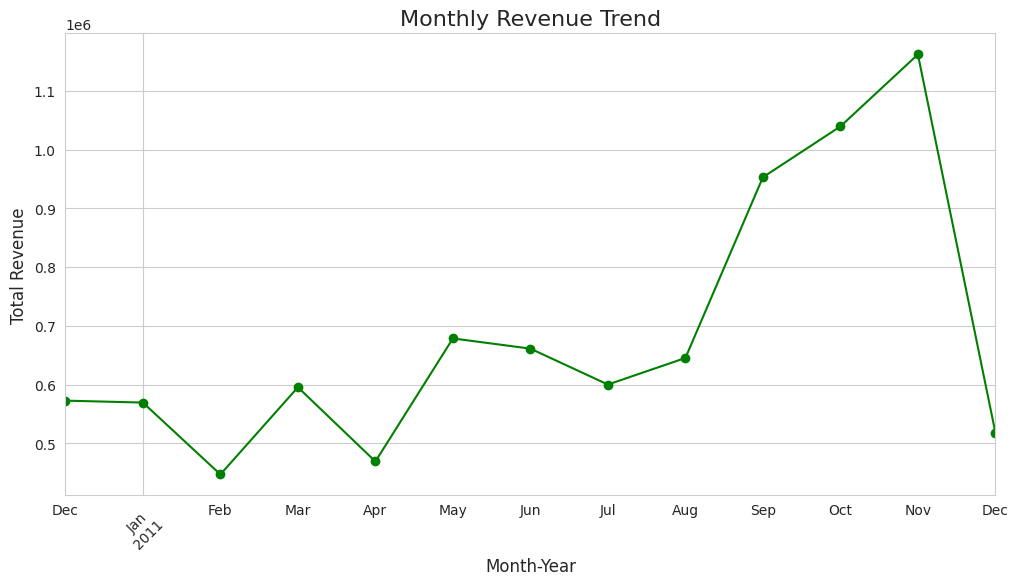

In [20]:
# 3. Plot: Monthly Revenue Trend
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['MonthYear'] = df['InvoiceDate'].dt.to_period('M')

monthly_revenue = df.groupby('MonthYear')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
monthly_revenue.plot(kind='line', marker='o', color='green')
plt.title('Monthly Revenue Trend', fontsize=16)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.xticks(rotation=45)
plt.show()

<ipython-input-21-081fa13094a9>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




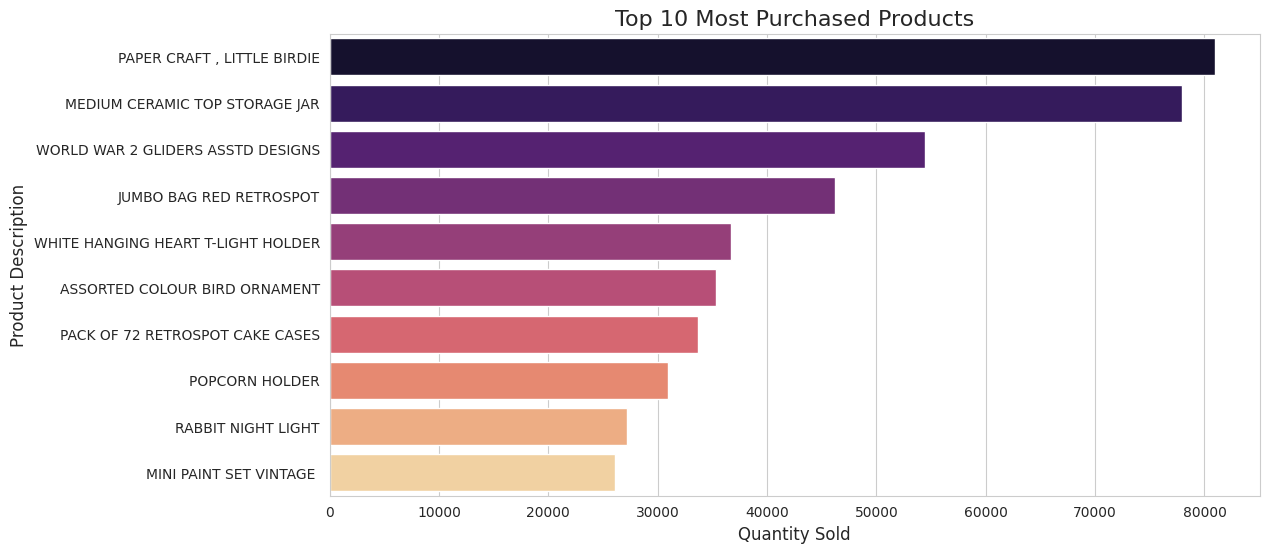

In [21]:
# 4. Plot: Top 10 Most Purchased Products
product_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(y=product_quantity.index, x=product_quantity.values, palette='magma')
plt.title('Top 10 Most Purchased Products', fontsize=16)
plt.xlabel('Quantity Sold', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.show()

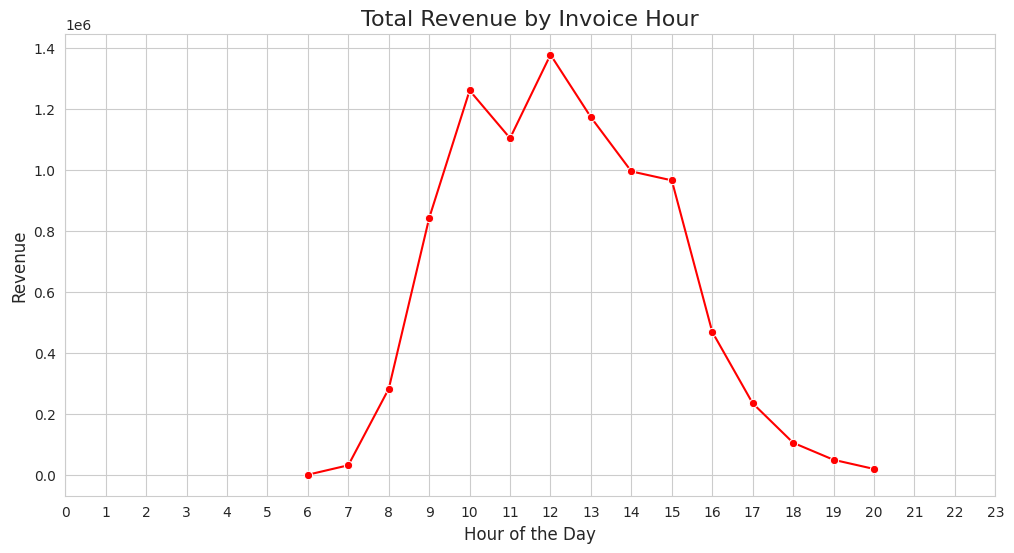

In [22]:
df['Hour'] = df['InvoiceDate'].dt.hour
hourly_revenue = df.groupby('Hour')['TotalPrice'].sum()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_revenue.index, y=hourly_revenue.values, marker='o', color='red')
plt.title('Total Revenue by Invoice Hour', fontsize=16)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Revenue', fontsize=12)
plt.xticks(range(0, 24))
plt.show()

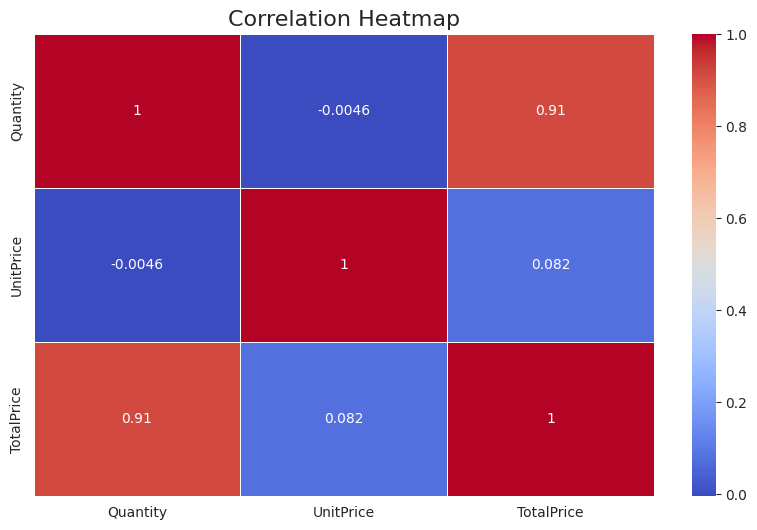

In [23]:
# 6. Plot: Correlation Heatmap of Numeric Features
plt.figure(figsize=(10, 6))
corr = df[['Quantity', 'UnitPrice', 'TotalPrice']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

# NLP

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Enter a review about the project: The product was great, but the delivery was not unto mark

VADER Sentiment Scores: {'neg': 0.0, 'neu': 0.797, 'pos': 0.203, 'compound': 0.3716}
TextBlob Sentiment Polarity: 0.8
TextBlob Subjectivity: 0.75


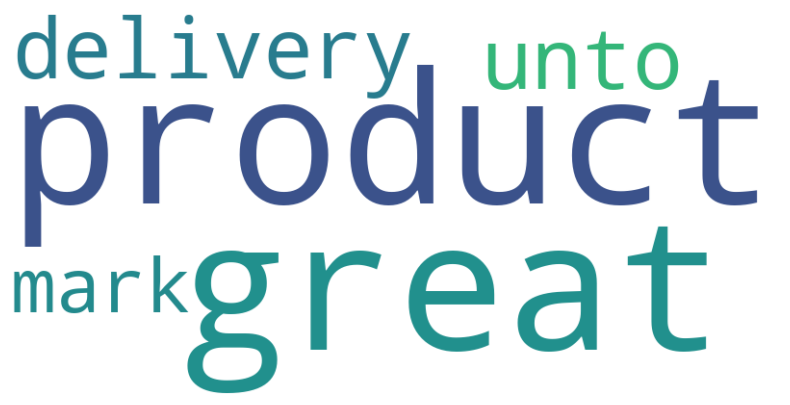

In [40]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Download necessary NLTK data
nltk.download('vader_lexicon')

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Sample text input
sample_review = input("Enter a review about the project: ")

# VADER Sentiment Analysis
vader_scores = sid.polarity_scores(sample_review)
print("\nVADER Sentiment Scores:", vader_scores)

# TextBlob Sentiment Analysis
text_blob = TextBlob(sample_review)
print(f"TextBlob Sentiment Polarity: {text_blob.sentiment.polarity}")
print(f"TextBlob Subjectivity: {text_blob.sentiment.subjectivity}")

# Generate a Word Cloud
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_wordcloud(sample_review)



TF-IDF Matrix:
    amazing       and        as      be       but     can   delayed  delivery  \
0  0.338301  0.000000  0.000000  0.0000  0.266721  0.0000  0.338301  0.338301   
1  0.000000  0.000000  0.000000  0.2857  0.225249  0.2857  0.000000  0.000000   
2  0.000000  0.331206  0.000000  0.0000  0.000000  0.0000  0.000000  0.000000   
3  0.000000  0.000000  0.408248  0.0000  0.000000  0.0000  0.000000  0.000000   

   design  everything  ...      of   product   service      team  terrible  \
0  0.0000    0.000000  ...  0.0000  0.338301  0.000000  0.000000  0.000000   
1  0.2857    0.000000  ...  0.2857  0.000000  0.000000  0.000000  0.000000   
2  0.0000    0.000000  ...  0.0000  0.000000  0.331206  0.331206  0.331206   
3  0.0000    0.408248  ...  0.0000  0.000000  0.000000  0.000000  0.000000   

        the  unresponsive    user       was    worked  
0  0.431867      0.000000  0.0000  0.533441  0.000000  
1  0.364717      0.000000  0.2857  0.000000  0.000000  
2  0.422808      0.

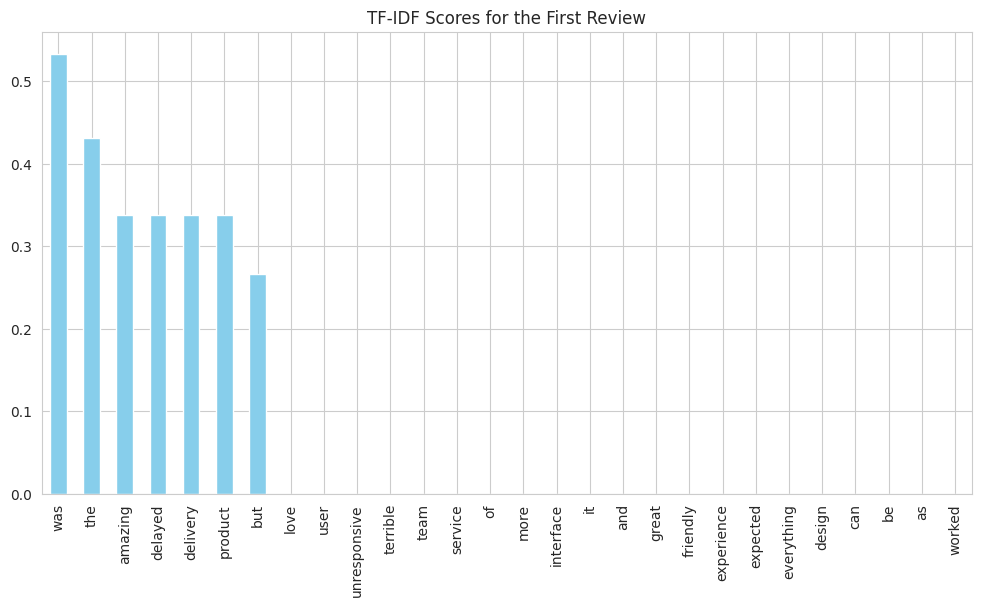

In [39]:
# Example list of reviews to extract features (you can replace with your own data)
reviews = [
    "The product was amazing, but the delivery was delayed.",
    "I love the design of the interface, but it can be more user-friendly.",
    "The service was terrible and the team was unresponsive.",
    "Great experience! Everything worked as expected."
]

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(reviews)

# Convert TF-IDF matrix to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print("\nTF-IDF Matrix:")
print(tfidf_df)

# Plot TF-IDF scores for the first review
plt.figure(figsize=(12, 6))
tfidf_df.iloc[0].sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("TF-IDF Scores for the First Review")
plt.show()


# Machine Learning - KMeans, Logistic Regression, Random Forest Regressor

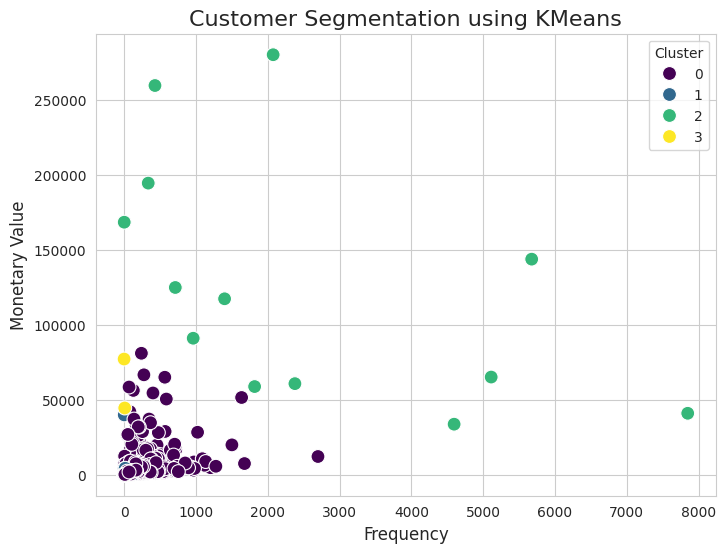

            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         325          1  77183.60        3
12347.0           1        182   4310.00        0
12348.0          74         31   1797.24        1
12349.0          18         73   1757.55        0
12350.0         309         17    334.40        3


In [24]:
# Import necessary libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Step 1: RFM Analysis (Recency, Frequency, Monetary)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,  # Recency
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalPrice': 'Monetary'})

# Step 2: Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Step 3: KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize the Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='viridis', s=100)
plt.title('Customer Segmentation using KMeans', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Monetary Value', fontsize=12)
plt.show()

# Display sample of RFM table with clusters
print(rfm.head())


              precision    recall  f1-score   support

           0       0.70      0.81      0.75       419
           1       0.90      0.83      0.87       883

    accuracy                           0.82      1302
   macro avg       0.80      0.82      0.81      1302
weighted avg       0.84      0.82      0.83      1302



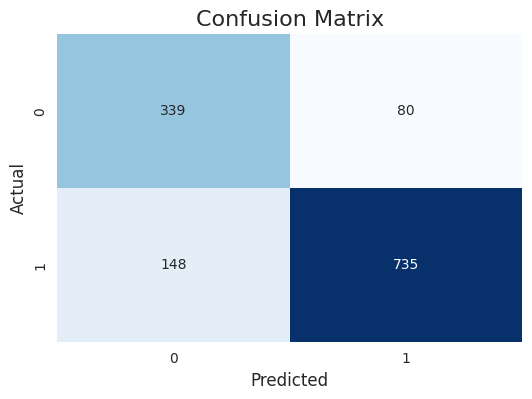

In [25]:
# Create a 'Repurchase' column (target) – if customer made > 1 purchase, label as 1 (Repurchase)
df_customers = df.groupby('CustomerID').agg({'InvoiceNo': 'nunique'}).reset_index()
df_customers['Repurchase'] = (df_customers['InvoiceNo'] > 1).astype(int)

# Features: Frequency and Monetary value from RFM Analysis
X = rfm[['Frequency', 'Monetary']]
y = df_customers['Repurchase']

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression()
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.show()


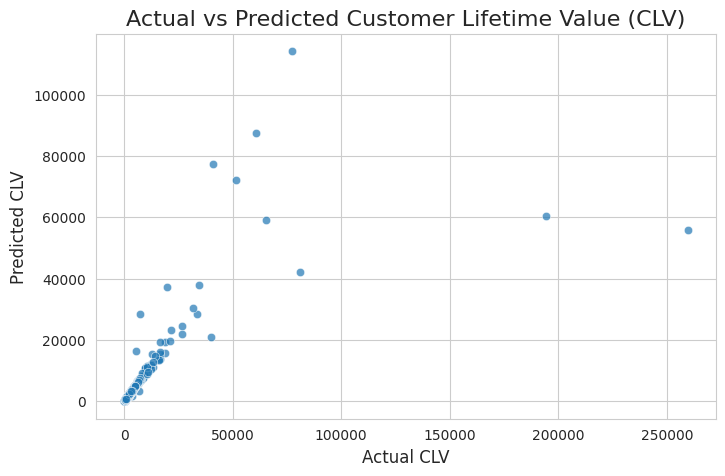

R2 Score: 0.53


In [26]:
# Feature Engineering for CLV Prediction
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']  # Average order value
rfm['RecencyMonths'] = rfm['Recency'] / 30  # Convert days to months

# Split Data for Regression (Target: Monetary)
X_clv = rfm[['Frequency', 'AvgOrderValue', 'RecencyMonths']]
y_clv = rfm['Monetary']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_clv, y_clv, test_size=0.3, random_state=42)

# Apply Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict CLV and Evaluate Model
y_pred_clv = rf_model.predict(X_test)

# Plot Predicted vs Actual CLV
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_clv, alpha=0.7)
plt.title('Actual vs Predicted Customer Lifetime Value (CLV)', fontsize=16)
plt.xlabel('Actual CLV', fontsize=12)
plt.ylabel('Predicted CLV', fontsize=12)
plt.show()

print(f'R2 Score: {rf_model.score(X_test, y_test):.2f}')


# Time Series Analysis

<ipython-input-29-1950d05bc61e>:6: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



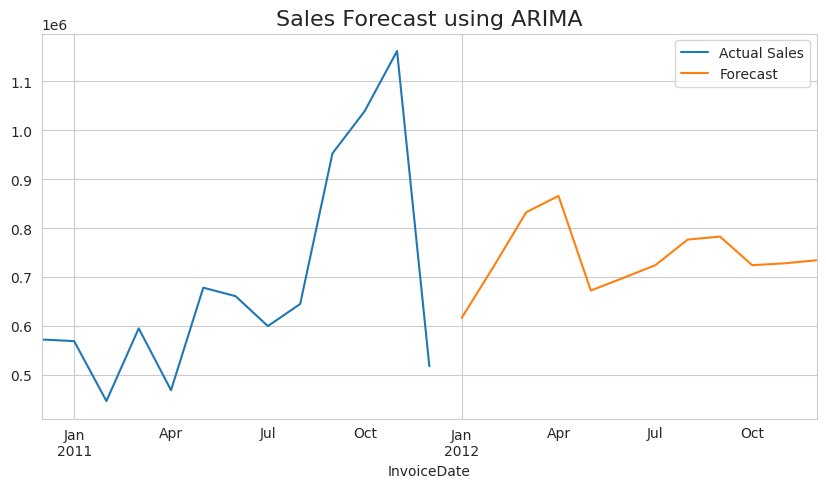

In [29]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare time-series data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate', inplace=True)
monthly_sales = df.resample('M')['TotalPrice'].sum()

# Fit ARIMA model
model = ARIMA(monthly_sales, order=(5, 1, 0))  # (p, d, q) parameters
arima_result = model.fit()

# Forecast next 12 months
forecast = arima_result.forecast(steps=12)

# Plot the forecast
plt.figure(figsize=(10, 5))
monthly_sales.plot(label='Actual Sales', legend=True)
forecast.plot(label='Forecast', legend=True)
plt.title('Sales Forecast using ARIMA', fontsize=16)
plt.show()


In [31]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Dashboard

In [43]:
# Initialize Dash app
app = Dash(__name__)

# Layout of the Dashboard
app.layout = html.Div([
    html.H1("RFM Customer Analytics Dashboard", style={'textAlign': 'center'}),

    # KPIs
    html.Div([
        html.Div([
            html.H3("Total Customers"),
            html.P(f"{rfm['CustomerID'].nunique()}")
        ], style={'width': '25%', 'display': 'inline-block', 'textAlign': 'center'}),

        html.Div([
            html.H3("Average Recency"),
            html.P(f"{rfm['Recency'].mean():.2f}")
        ], style={'width': '25%', 'display': 'inline-block', 'textAlign': 'center'}),

        html.Div([
            html.H3("Average Frequency"),
            html.P(f"{rfm['Frequency'].mean():.2f}")
        ], style={'width': '25%', 'display': 'inline-block', 'textAlign': 'center'}),

        html.Div([
            html.H3("Average Monetary Value"),
            html.P(f"${rfm['Monetary'].mean():.2f}")
        ], style={'width': '25%', 'display': 'inline-block', 'textAlign': 'center'}),
    ], style={'marginTop': '20px', 'marginBottom': '40px'}),

    # Dropdown for selecting cluster
    dcc.Dropdown(
        id='cluster-selector',
        options=[{'label': f'Cluster {i}', 'value': i} for i in rfm['Cluster'].unique()],
        value=0,
        style={'width': '50%', 'margin': 'auto'}
    ),

    # Scatter plots for RFM components
    html.Div([
        dcc.Graph(id='recency-vs-frequency-chart'),
        dcc.Graph(id='frequency-vs-monetary-chart')
    ], style={'display': 'flex', 'justifyContent': 'space-around'}),

    # Pie chart for cluster composition
    dcc.Graph(id='cluster-composition-pie-chart')
])

# Callback to update RFM scatter plots
@app.callback(
    [Output('recency-vs-frequency-chart', 'figure'),
     Output('frequency-vs-monetary-chart', 'figure')],
    [Input('cluster-selector', 'value')]
)
def update_scatter_plots(cluster):
    filtered_data = rfm[rfm['Cluster'] == cluster]

    # Recency vs Frequency Scatter Plot
    fig1 = px.scatter(filtered_data, x='Recency', y='Frequency', color='Cluster',
                      size='Frequency', title=f'Cluster {cluster} - Recency vs Frequency')

    # Frequency vs Monetary Scatter Plot
    fig2 = px.scatter(filtered_data, x='Frequency', y='Monetary', color='Cluster',
                      size='Monetary', title=f'Cluster {cluster} - Frequency vs Monetary')

    return fig1, fig2

# Callback to update cluster composition pie chart
@app.callback(
    Output('cluster-composition-pie-chart', 'figure'),
    [Input('cluster-selector', 'value')]
)
def update_pie_chart(cluster):
    filtered_data = rfm[rfm['Cluster'] == cluster]
    fig = px.pie(filtered_data, names='Cluster', title='Cluster Composition')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

<IPython.core.display.Javascript object>